In [1]:
!git clone https://github.com/ayanokojix21/NeuroFormer2.0.git

Cloning into 'NeuroFormer2.0'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 112 (delta 15), reused 28 (delta 7), pack-reused 68 (from 1)
Receiving objects: 100% (112/112), 82.28 MiB | 24.13 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Filtering content: 100% (2/2), 154.18 MiB | 52.23 MiB/s, done.


In [2]:
%cd NeuroFormer2.0

/kaggle/working/NeuroFormer2.0


In [3]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import json

In [4]:
from model.neuroformer import NeuroFormer
from data.dataloader import load_data
from tokenizers import Tokenizer

In [5]:
# Setting Device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# For Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [7]:
# Loading Custom trained tokenizer
tokenizer = Tokenizer.from_file("tokenizer/bpe_tokenizer.json")
vocab_size = tokenizer.get_vocab_size()
print(f"Loaded tokenizer with vocab size: {vocab_size}")

Loaded tokenizer with vocab size: 1000


In [8]:
# Getting Special Token Ids
special_tokens = {
    'pad_id': tokenizer.token_to_id("<PAD>"),
    'unk_id': tokenizer.token_to_id("<UNK>"),
    'bos_id': tokenizer.token_to_id("<BOS>"),
    'eos_id': tokenizer.token_to_id("<EOS>")
}
print(f"Special tokens: {special_tokens}")

Special tokens: {'pad_id': 996, 'unk_id': 997, 'bos_id': 998, 'eos_id': 999}


In [9]:
# Model HyperParameters
vocab_size = vocab_size
sequence_length = 512
d_model = 512
num_heads = 8
hidden = 4 * d_model
num_layers = 6
drop_prob = 0.2

In [10]:
# Training HyperParameters
batch_size = 32
total_steps = 4000
lr = 3e-4
weight_decay = 0.01
max_grad_norm = 1.0
eval_interval = 200
best_model_path = 'model/best_model.pt'
os.makedirs('model', exist_ok=True)

In [13]:
train_path = '/kaggle/working/NeuroFormer2.0/data/train.txt'
valid_path = '/kaggle/working/NeuroFormer2.0/data/val.txt'

with open(train_path, 'r', encoding='utf-8') as f:
    train_text = f.read()

with open(valid_path, 'r', encoding='utf-8') as f:
    valid_text = f.read()

In [14]:
train_loader = load_data(
    text=train_text,
    tokenizer=tokenizer,
    batch_size=batch_size,
    max_length=sequence_length,
    stride=sequence_length // 16,
    shuffle=True,
    drop_last=True
)

valid_loader = load_data(
    text=valid_text,
    tokenizer=tokenizer,
    batch_size=batch_size,
    max_length=sequence_length,
    stride=sequence_length // 16,
    shuffle=False,
    drop_last=False
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(valid_loader)}")

Training batches: 5747
Validation batches: 639


In [15]:
model = NeuroFormer(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    d_model=d_model,
    num_heads=num_heads,
    hidden=hidden,
    num_layers=num_layers,
    drop_prob=drop_prob
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 19,689,472


In [16]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=special_tokens['pad_id'])

lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=3e-4,
    min_lr=1e-6,
)

In [17]:
def evaluate_model():
    """Evaluate model on validation set"""

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for input_ids, target_ids in valid_loader:
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))

            total_loss += loss.item()

    avg_loss = total_loss / len(valid_loader)

    return avg_loss

In [18]:
def train_model():
    """Main training loop"""

    model.train()
    best_val_loss = float('inf')
    step = 0

    train_losses, val_losses, val_steps = [], [], []

    while step < total_steps:
        for input_ids, target_ids in train_loader:
            if step >= total_steps:
                break

            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            train_losses.append(loss.item())

            if step % eval_interval == 0 or step == total_steps-1:
                val_loss = evaluate_model()
                val_losses.append(val_loss)
                val_steps.append(step)

                model.train()

                print(f"Step {step:4d} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

                lr_scheduler.step(val_loss)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), best_model_path)
                    print(f"Best model saved Val Loss: {val_loss:.4f}")

            step += 1

    return train_losses, val_losses, val_steps

In [19]:
def visualize(train_losses, val_losses, val_steps):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_steps, val_losses, label='Val Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [20]:
def test_generation():
    """Test text generation after training"""

    model.eval()

    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))

    test_prompts = [
        "To be or not to be",
        "Romeo and Juliet",
        "The quick brown fox"
    ]

    for prompt in test_prompts:

        full_prompt = f"<bos>{prompt}"
        encoded = tokenizer.encode(full_prompt)
        input_ids = torch.tensor([encoded.ids], dtype=torch.long).to(device)

        with torch.no_grad():
            generated = model.generate(
                input_ids=input_ids,
                max_length=500,
                temperature=1.3,
                top_k=100,
                top_p=0.9,
                eos_token_id=special_tokens['eos_id']
            )

        generated_text = tokenizer.decode(generated[0].cpu().tolist())
        print(f"Prompt: '{prompt}'")
        print(f"Generated: '{generated_text}'\n")

In [21]:
train_losses, val_losses, val_steps = train_model()

Step    0 | Val Loss: 6.6645 | LR: 0.000300
Best model saved Val Loss: 6.6645
Step  200 | Val Loss: 3.8870 | LR: 0.000300
Best model saved Val Loss: 3.8870
Step  400 | Val Loss: 3.6784 | LR: 0.000300
Best model saved Val Loss: 3.6784
Step  600 | Val Loss: 3.5005 | LR: 0.000300
Best model saved Val Loss: 3.5005
Step  800 | Val Loss: 3.2511 | LR: 0.000300
Best model saved Val Loss: 3.2511
Step 1000 | Val Loss: 3.0377 | LR: 0.000300
Best model saved Val Loss: 3.0377
Step 1200 | Val Loss: 2.9011 | LR: 0.000300
Best model saved Val Loss: 2.9011
Step 1400 | Val Loss: 2.8062 | LR: 0.000300
Best model saved Val Loss: 2.8062
Step 1600 | Val Loss: 2.7304 | LR: 0.000300
Best model saved Val Loss: 2.7304
Step 1800 | Val Loss: 2.6747 | LR: 0.000300
Best model saved Val Loss: 2.6747
Step 2000 | Val Loss: 2.6305 | LR: 0.000300
Best model saved Val Loss: 2.6305
Step 2200 | Val Loss: 2.5945 | LR: 0.000300
Best model saved Val Loss: 2.5945
Step 2400 | Val Loss: 2.5652 | LR: 0.000300
Best model saved Val

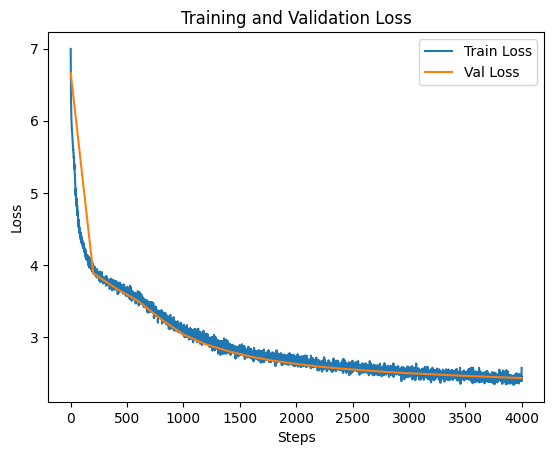

In [22]:
visualize(train_losses, val_losses, val_steps)

In [23]:
test_generation()

Prompt: 'To be or not to be'
Generated: '<bos>To be or not to be the right to ask WHURL.K.</b>
<CHAR_KOTCHING> No.
<CHAR_BIANCA> You know, the ironus will retire. I didn't <b>you</b>
'

Prompt: 'Romeo and Juliet'
Generated: '<bos>Romeo and Juliet Janet?
<CHAR_CLAUDIA> Nigger's extremely lit particular. Make sure that'll pull the spider's mouth fun.
<CHAR_BOBBY> Six ways at someone was still honest. For Jason, you know why? Do as Philly told me you'd be doubt and have some of that for that you want to know why they tell me, I'll be damaged if they asked. She tried to deal with that except an encourague to live. That's an encourage ballist or something. I'd just pull the prive, a payroll in stair soon as the point fantasy they made your pleasant cousin.
<CHAR_CLAUDIA> Whose brilliant are you in sit?
<CHAR_BOBBY> Well, we don't need this one teenaged. I don't know what's on the way we thought we tried.
'

Prompt: 'The quick brown fox'
Generated: '<bos>The quick brown fox I think you're te